In [1]:
import cv2
import numpy as np

np.seterr(invalid='ignore')
import matplotlib.pyplot as plt
import glob
from scipy.ndimage import filters 



## Quality Based Comparision


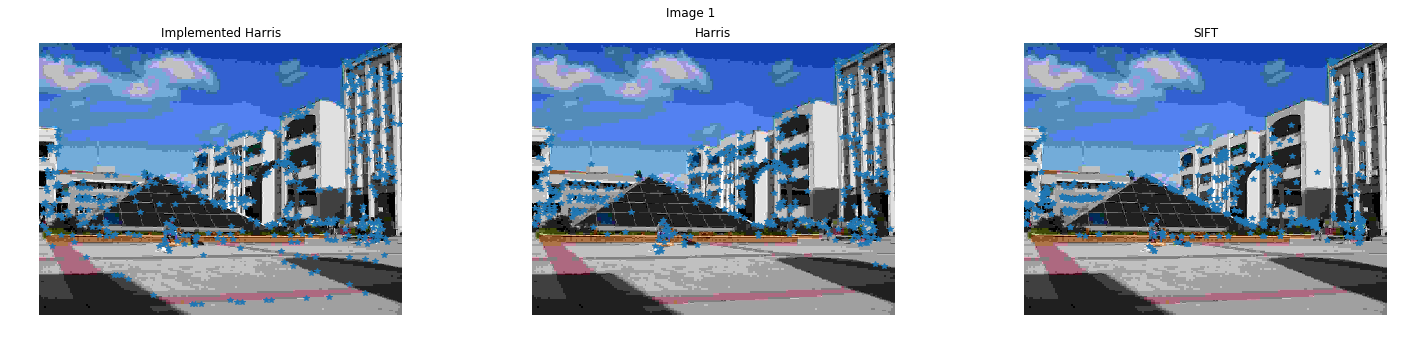

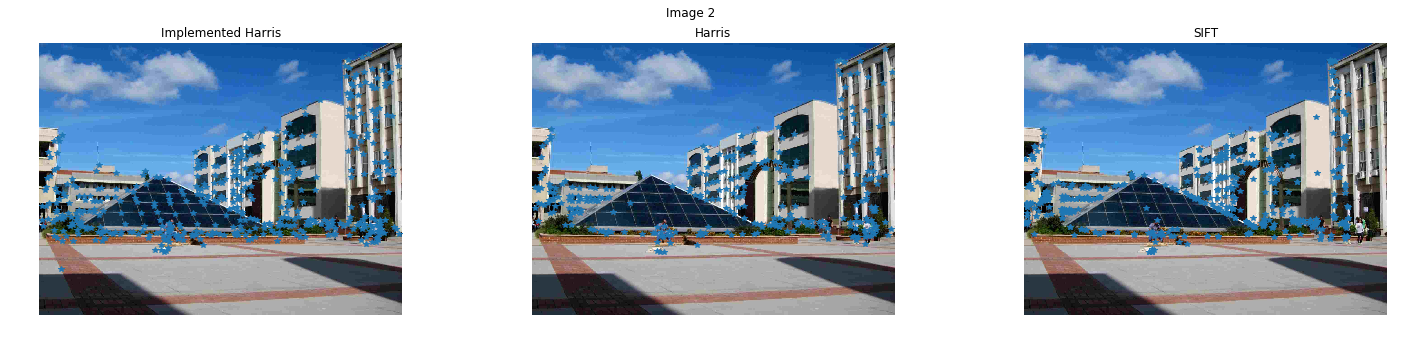

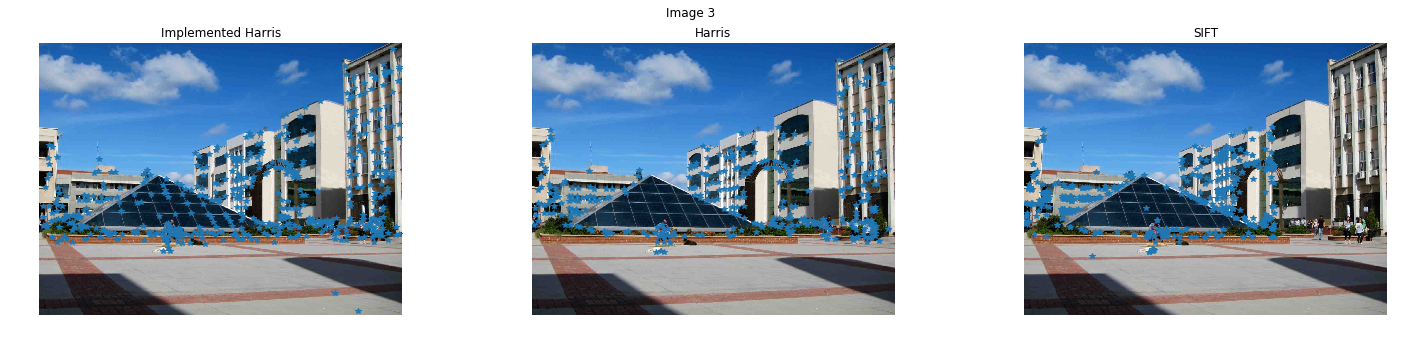

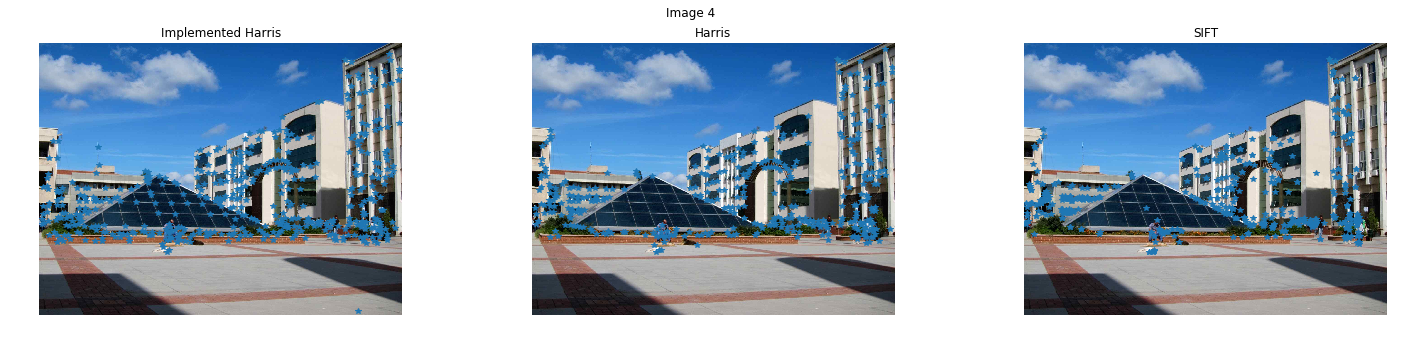

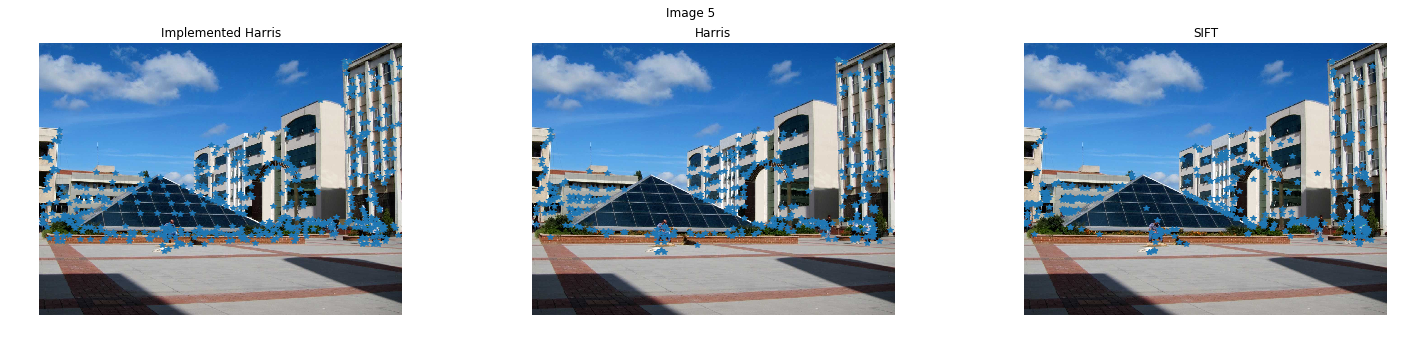

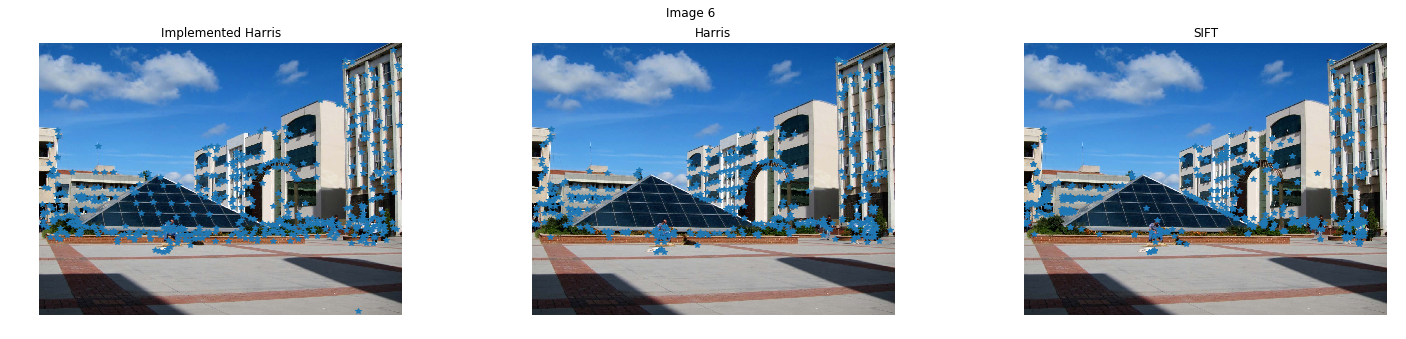

In [17]:
file_names=glob.glob(r"Images/jpeg_quality/*.jpg")
harris_results=[]
sift_results=[]
manual_harris_results=[]

for f,idx in zip(file_names,range(len(file_names))):
    fig = plt.figure(figsize=(25,5))
    img=cv2.imread(f)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    cv_Harris=calc_harris(gray)
    cv_Sift=calc_sift(gray)
    
    manual_harris=compute_harris_response(gray)
#     plotharrispoints(gray,manual_harris)
    img=img[...,::-1]
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.plot([p[1]for p in manual_harris],[p[0]for p in manual_harris],'*')
    plt.title("Implemented Harris")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.plot([p[1]for p in cv_Harris],[p[0]for p in cv_Harris],'*')
    plt.title("Harris")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.plot([p[1]for p in cv_Sift],[p[0]for p in cv_Sift],'*')
    plt.title("SIFT")
    plt.axis('off')
    fig.suptitle("Image "+ str(idx+1))

    plt.show()
    
    harris_results.append(cv_Harris)
    sift_results.append(cv_Sift)
    manual_harris_results.append(manual_harris)

In [18]:
sift_repeatability=[]
harris_repeatability=[]
manual_repeatability=[]
for i in range(len(file_names))[1:]:
    sift_repeatability.append(calc_repeatability(sift_results[0],sift_results[i]))
    harris_repeatability.append(calc_repeatability(harris_results[0],harris_results[i]))
    manual_repeatability.append(calc_repeatability(manual_harris_results[0],manual_harris_results[i]))

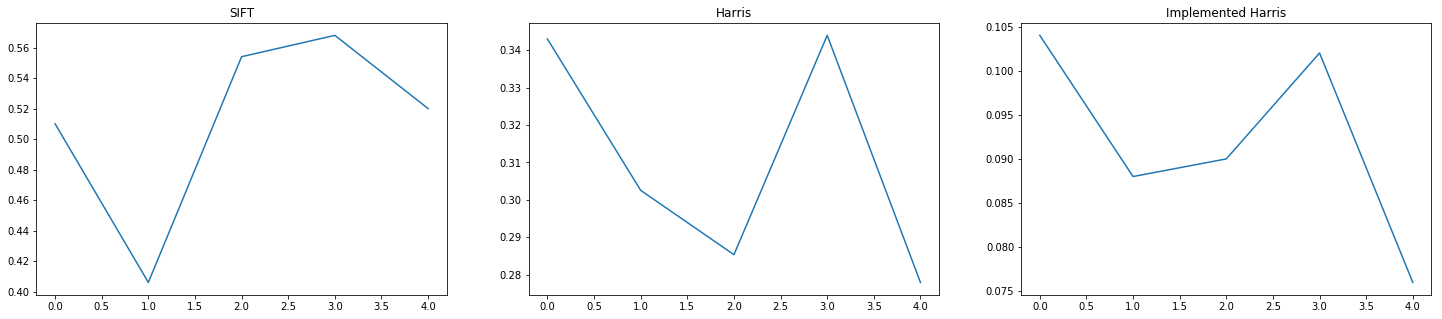

In [19]:
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 1)
plt.plot(range(len(file_names)-1),sift_repeatability)
plt.title("SIFT")
plt.subplot(1, 3, 2)
plt.plot(range(len(file_names)-1),harris_repeatability)
plt.title("Harris")
plt.subplot(1, 3, 3)
plt.plot(range(len(file_names)-1),manual_repeatability)
plt.title("Implemented Harris")
plt.show()

In [20]:
print("Sift")
for s in sift_results:
    print(len(s))
print("Harris")
for s in harris_results:
    print(len(s))
print("Manual Harris")
for s in manual_harris_results:
    print(len(s))

Sift
500
500
500
500
500
500
Harris
421
312
357
389
346
385
Manual Harris
500
500
500
500
500
500


In [21]:
print("Sift")
for s in sift_repeatability:
    print(s)
print("Harris")
for s in harris_repeatability:
    print(s)
print("Manual Harris")
for s in manual_repeatability:
    print(s)

Sift
0.51
0.406
0.554
0.568
0.52
Harris
0.34294871794871795
0.3025210084033613
0.2853470437017995
0.3439306358381503
0.2779220779220779
Manual Harris
0.104
0.088
0.09
0.102
0.076


In [70]:
len(sift_results[1])

6240

In [16]:
def calc_repeatability(sift,sift2):
    if len(sift)>len(sift2):
        n1=sift
        n2=sift2
    else:
        n1=sift2
        n2=sift
    offset=4
    count=0
    matches=set()
    for (x2,y2),idx2 in zip(n2,range(len(n2))):
        for (x1,y1),idx1 in zip(n1,range(len(n1))):
            if x2+offset>x1 and y2+offset>y1 and x2-offset<x1 and y2-offset<y1:
                if idx1 not in matches:
                    matches.add(idx1)
                    count+=1
    return count/len(n2)

In [9]:
img=cv2.imread("Images/img1.png",0)

def calc_harris(img):
#     gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray=img
    block_size = 2
    aperture = 3
    free_parameter = 0.04
    dst = cv2.cornerHarris(gray, block_size, aperture, free_parameter)
    #result is dilated for marking the corners, not important
    # dst = cv2.dilate(dst,None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    res= getharrispoints(dst)
    return res
#     res=np.array(np.where(dst>0.001*dst.max())).T
#     print()
#     if len(res)>500:
#         return res[res.argsort()][0:500]
#     else:
#         return res
    # img[dst>0.01*dst.max()]=[0,0,255]
    # plt.imshow(img)
    # plt.show()
def calc_sift(img):
#     gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray=img

    sift = cv2.xfeatures2d.SIFT_create()
    kp,descs = sift.detectAndCompute(gray,None)
    res=np.array([a.response for a in kp])
    kp=np.array(kp)[np.max(res)*0.5<res]
    if len(kp)>500:
        kp=kp[:500]
    # plt.figure(figsize=(30,30))
    # plt.imshow(a)
    # plt.show()
    return np.array([[p.pt[1],p.pt[0]] for p in kp]).astype(np.int64)



def compute_harris_response(im,sigma=0.5):
#     im= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # derivatives	
    imx=np.zeros(im.shape)	
    filters.gaussian_filter(im,	(sigma,	sigma),(0,1),	imx)
    imy=np.zeros(im.shape)			
    filters.gaussian_filter(im,	(sigma,	sigma),(1,0),	imy)

    # compute components of the Harris matrix
    Wxx=filters.gaussian_filter(imx*imx,sigma)
    Wxy=filters.gaussian_filter(imx*imy,sigma)
    Wyy=filters.gaussian_filter(imy*imy,sigma)
    # determinant and trace
    Wdet=Wxx*Wyy-Wxy**2
    Wtr=Wxx+Wyy
    harrisim=Wdet/Wtr
#     return np.array(np.where((np.nan_to_num(harrisim)>0.5*np.max((np.nan_to_num(harrisim)))))).T
    return getharrispoints(harrisim)


def getharrispoints(harrisim,threshold=0.04,min_dist=10):

    #Findtopcornercandidatesaboveathreshold
    maxnum=0
    harrisim=np.nan_to_num(harrisim)
    maxnum=np.max(harrisim)
    
    cornerthreshold=maxnum*threshold
    #cornerthreshold=np.nantonum(cornerthreshold)
    harrisimt=(harrisim>cornerthreshold)*1
    #Getcoordinatesofcandiates
    coords=np.array(harrisimt.nonzero()).T
    #...andtheirvalues
    candidatevalues=[harrisim[c[0],c[1]]for c in coords]
    #Sortcandidates
    index=np.argsort(candidatevalues)
    #storeallowedpointlocationsinarray
    allowedlocations=np.zeros(harrisim.shape)
    allowedlocations[min_dist:-min_dist,min_dist:-min_dist]=1
    #selectthebestpointstakingmin_distanceintoaccount
    filteredcoords=[]
    for i in index:
        if allowedlocations[coords[i,0],coords[i,1]]==1:
            filteredcoords.append(coords[i])
            allowedlocations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),(coords[i,1]-min_dist):(coords[i,1]+min_dist)]=0
        
        if len(filteredcoords)==500:
            break
    return np.array(filteredcoords)

In [4]:
harris=calc_harris(img)
sift=calc_sift(img)
img2=cv2.imread("Images/img1.png")
sift2=calc_sift(img2)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\imgproc\src\corner.cpp:269: error: (-215:Assertion failed) src.type() == (((0) & ((1 << 3) - 1)) + (((1)-1) << 3)) || src.type() == (((5) & ((1 << 3) - 1)) + (((1)-1) << 3)) in function 'cv::cornerEigenValsVecs'


In [14]:

if len(sift)>len(sift2):
    n1=sift
    n2=sift2
else:
    n1=sift2
    n2=sift
offset=4
count=0
matches=set()
for (x2,y2),idx2 in zip(n2,range(len(n2))):
    for (x1,y1),idx1 in zip(n1,range(len(n1))):
        if x2+offset>x1 and y2+offset>y1 and x2-offset<x1 and y2-offset<y1:
            if idx1 not in matches:
                matches.add(idx1)
                count+=1
        

NameError: name 'sift' is not defined

In [8]:
H12=np.loadtxt("Images/H1to2p")

In [5]:
img1=cv2.imread("Images/img1.png")
sift1=calc_sift(img1)
img2=cv2.imread("Images/img2.png")
sift2=calc_sift(img2)

In [172]:
sift1

array([[320,   2],
       [284,   3],
       [277,   3],
       ...,
       [434, 794],
       [539, 796],
       [491, 796]], dtype=int64)

In [164]:
sift1.shape

(2678, 2)

In [169]:
np.ones(sift1.shape[0]).shape

(2678,)

In [ ]:
np.concatenate()

In [309]:
cv2.warpPerspective(img1,img2,H12)

SystemError: new style getargs format but argument is not a tuple

In [26]:
h12_sift1=np.dot(np.linalg.inv(H12),np.column_stack((sift2,np.ones(sift2.shape[0]))).T)
y_h12=h12_sift1[0,:]/h12_sift1[2,:]
x_h12=h12_sift1[1,:]/h12_sift1[2,:]
homog1=np.vstack((y_h12,x_h12)).T.astype(np.int64)


In [347]:
np.dot(H12
       ,np.column_stack((sift1,np.ones(sift1.shape[0]))).T)

array([[242.72060456, 211.3613519 , 205.20296442, ..., 590.47821248,
        683.47893344, 641.24999072],
       [ 96.18864636, 103.74730882, 105.03456808, ..., 818.494518  ,
        801.06257306, 809.8894937 ],
       [  1.06282053,   1.0557336 ,   1.0543587 , ...,   1.07252766,
          1.09311912,   1.08369124]])

In [354]:
homog1=np.vstack((y_h12,x_h12)).T.astype(np.int64)

In [353]:
2+2

4

In [264]:
h12_sift1

array([[427.28832042, -63.47813475,   0.91505787],
       [389.38097092, -71.03589494,   0.92238237],
       [382.07733155, -72.69682211,   0.92379031],
       ...,
       [272.37903482, 743.01884287,   0.95840053],
       [381.24207419, 769.9010525 ,   0.9374488 ],
       [331.15997565, 758.51183758,   0.94710324]])

In [408]:
np.max(des1[0])

164.0

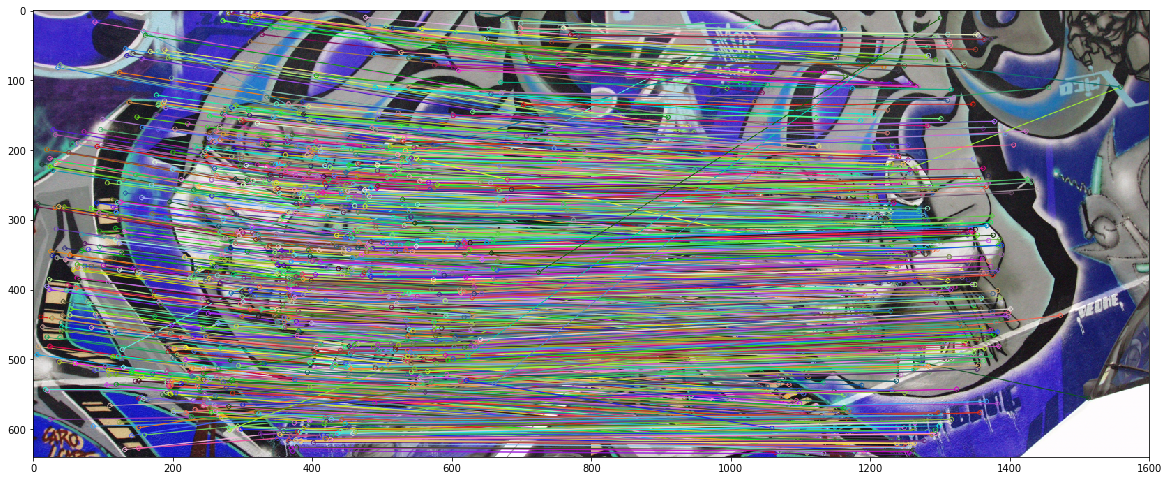

In [409]:
sift = cv2.xfeatures2d.SIFT_create()
# Initiate SIFT detector

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
plt.figure(figsize=(20,20))

plt.imshow(cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None, flags=2))
plt.show()

In [419]:
np.max(np.add(np.abs(np.min(homog1,axis=0)),homog1),axis=0)

array([1040,  959], dtype=int64)

In [20]:
np.add(np.abs(np.min(homog1,axis=0)),homog1)

array([[390,  96],
       [449,  83],
       [285, 124],
       ...,
       [508, 830],
       [491, 838],
       [403, 877]], dtype=int64)

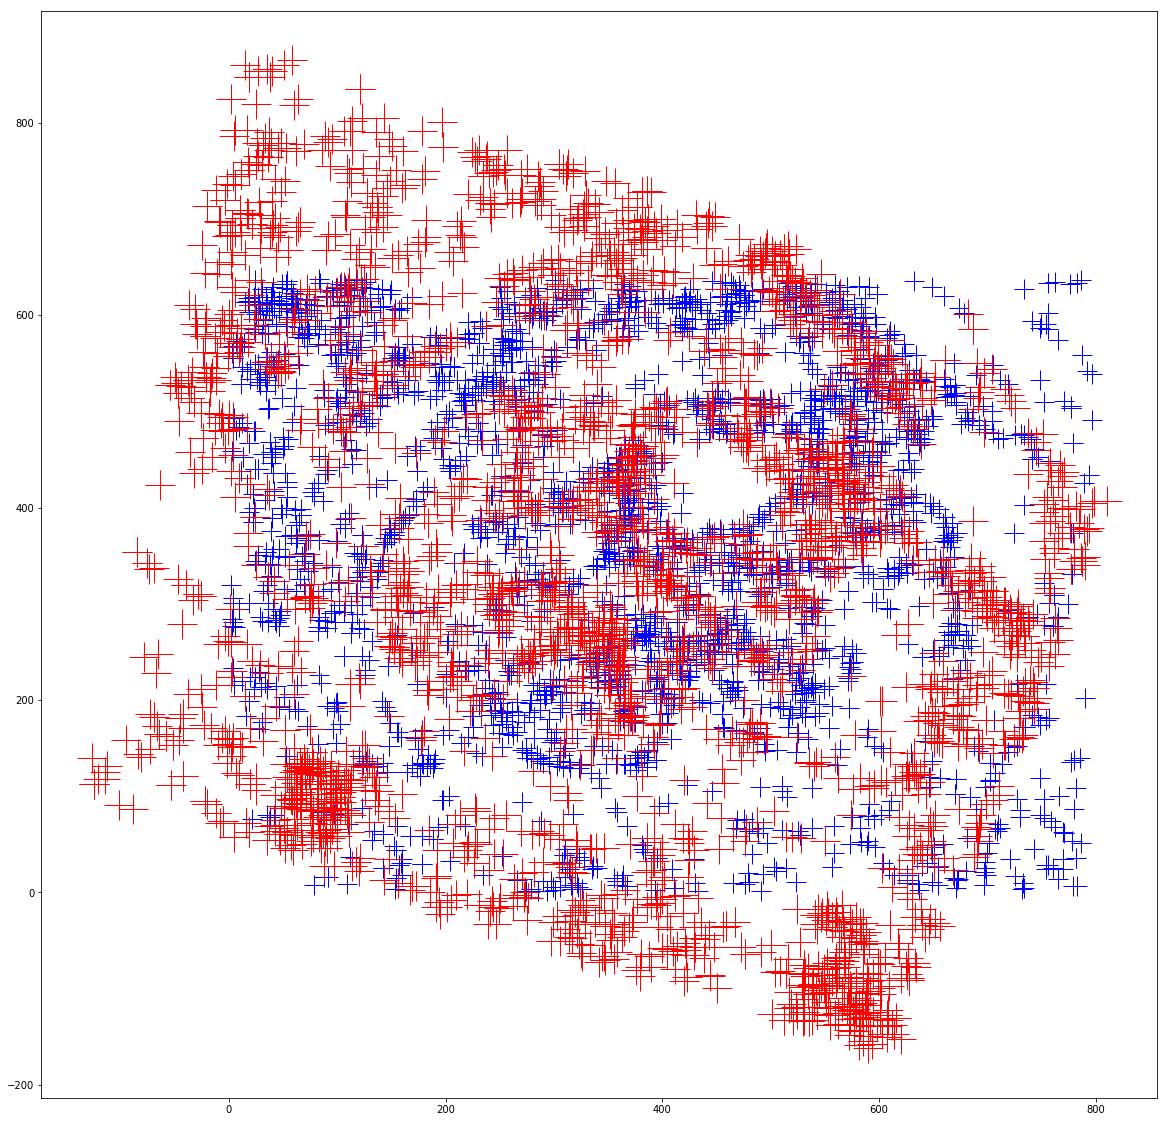

In [29]:
plt.figure(figsize=(20,20))
# plt.imshow(cv2.warpPerspective(img1,H12,(img2.shape[0],img2.shape[1])))
plt.plot(sift1[:,1],sift1[:,0],"b+",ms=20)
# plt.imshow(img1)
plt.plot(homog1[:,1],homog1[:,0],"r+",ms=30)
plt.show()

In [330]:
homog1

array([[228,  90],
       [200,  98],
       [194,  99],
       ...,
       [550, 763],
       [625, 732],
       [591, 747]], dtype=int64)

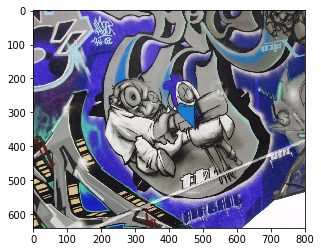

In [366]:
plt.imshow(img2)
plt.show()

In [312]:
np.max(homog1,axis=0)

array([688, 896], dtype=int64)

In [251]:
np.min(homog1,axis=0)

array([-7, 47], dtype=int64)

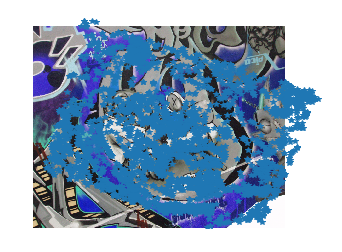

In [25]:
plotharrispoints(img2,homog1)

In [421]:
homog1=np.add(np.abs(np.min(homog1,axis=0)),homog1)
if len(homog1)>len(sift2):
    n1=homog1
    n2=sift2
else:
    n1=sift2
    n2=homog1
offset=3
count=0
matches=set()
for (x2,y2),idx2 in zip(n2,range(len(n2))):
    for (x1,y1),idx1 in zip(n1,range(len(n1))):
        if x2+offset>x1 and y2+offset>y1 and x2-offset<x1 and y2-offset<y1:
            if idx1 not in matches:
                matches.add(idx1)
                count+=1
        

In [422]:
count

212

In [84]:
img1=cv2.imread("Images/gaussian_noise/1.jpg")
sift1=calc_sift(img1)
img2=cv2.imread("Images/gaussian_noise/2.jpg")
sift2=calc_sift(img2)

In [86]:

if len(sift1)>len(sift2):
    n1=sift1
    n2=sift2
else:
    n1=sift2
    n2=sift1
offset=2
count=0
matches=set()
for (x2,y2),idx2 in zip(n2,range(len(n2))):
    for (x1,y1),idx1 in zip(n1,range(len(n1))):
        if x2+offset>x1 and y2+offset>y1 and x2-offset<x1 and y2-offset<y1:
            if idx1 not in matches:
                matches.add(idx1)
                count+=1
        

In [89]:
len(sift2)

8156

In [88]:
count

1590

In [142]:
(53,53) in matches 

True

In [146]:
idx2

2677

In [296]:
import cv2
import numpy as np

w, h = 512, 512
src = np.array(
    [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32)
dst = np.array(
    [[300, 350], [800, 300], [900, 923], [161, 923]], dtype=np.float32)

m = cv2.getPerspectiveTransform(src, dst)
result = cv2.perspectiveTransform(src[None, :, :], m)

In [304]:
cv2.perspectiveTransform(src=cv2.imread("Images/img1.png"),m=H12)

error: OpenCV(3.4.2) C:\projects\opencv-python\opencv\modules\core\src\matmul.cpp:2268: error: (-215:Assertion failed) scn + 1 == m.cols in function 'cv::perspectiveTransform'


In [303]:
m

array([[ 8.52826893e-01, -3.70490257e-01,  3.00000000e+02],
       [-1.44964866e-01,  5.56783787e-01,  3.50000000e+02],
       [-1.57058360e-04, -6.11643486e-04,  1.00000000e+00]])

In [290]:
cv2.imread("Images/img1.png").shape

(640, 800, 3)

In [282]:
count

2678

In [150]:
len(matches)

2678

In [127]:
count

3588

In [128]:
len(sift)

2678

In [130]:
len(sift2)

2678

In [124]:
sift

array([[320,   2],
       [284,   3],
       [277,   3],
       ...,
       [434, 794],
       [539, 796],
       [491, 796]], dtype=int64)

In [125]:
sift2

array([[320,   2],
       [284,   3],
       [277,   3],
       ...,
       [434, 794],
       [539, 796],
       [491, 796]], dtype=int64)

In [75]:

block_size = 2
aperture = 3
free_parameter = 0.04
dst = cv2.cornerHarris(gray, block_size, aperture, free_parameter)
filteredcoords=getharrispoints(dst,0.4,10)


In [27]:
def plotharrispoints(image,filteredcoords):

    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1]for p in filteredcoords],[p[0]for p in filteredcoords],'*')
    plt.axis('off')
    plt.show()
    plt.show()

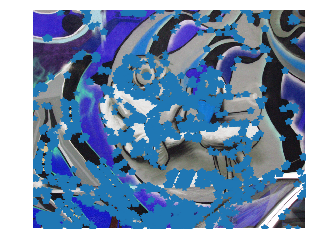

In [90]:
harrisim=compute_harris_response(img,0.5)
# filteredcoords=getharrispoints(harrisim,0.4,10)
filteredcoords=np.array(np.where((np.nan_to_num(harrisim)>free_parameter*np.max((np.nan_to_num(harrisim)))))).T
plotharrispoints(img,filteredcoords)


In [106]:
filteredcoords.size

21062

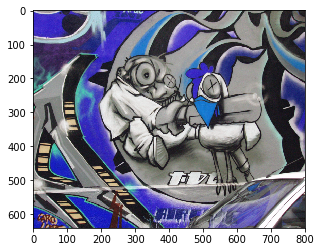

In [103]:
dst=calc_harris(img)
img[dst[0],dst[1],:]=[0,0,255]

plt.imshow(img)
plt.show()

In [95]:
calc_harris(img).shape

(3316, 2)

In [76]:
len(filteredcoords)

26

In [ ]:
filteredcoords=getharrispoints(harrisim,0.4,10)


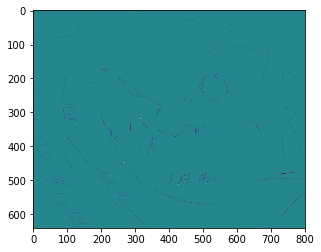

In [37]:
plt.imshow(cv2.normalize(dst,None,0,255,cv2.NORM_MINMAX,cv2.CV_32FC1))
plt.show()

In [ ]:
normalize(dst, dst_norm, 0, 255, NORM_MINMAX, CV_32FC1, Mat());


In [25]:
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]
ma

(640, 800)

In [26]:
descs.shape

(2678, 128)

In [30]:
a

array([[[215, 209, 219],
        [215, 206, 216],
        [207, 196, 206],
        ...,
        [ 27,  29,  20],
        [ 28,  29,  31],
        [ 18,  17,  30]],

       [[211, 206, 217],
        [217, 210, 221],
        [219, 209, 220],
        ...,
        [ 42,  33,  29],
        [ 35,  24,  28],
        [ 32,  17,  32]],

       [[213, 210, 222],
        [215, 209, 222],
        [215, 206, 219],
        ...,
        [ 39,  29,  30],
        [ 39,  27,  32],
        [ 35,  22,  35]],

       ...,

       [[ 29,  23, 178],
        [ 22,  20, 174],
        [ 22,  25, 176],
        ...,
        [ 47,  37,  39],
        [ 46,  36,  37],
        [ 51,  40,  40]],

       [[ 17,  23, 178],
        [ 24,  29, 186],
        [ 28,  32, 189],
        ...,
        [ 47,  41,  41],
        [ 47,  39,  41],
        [ 47,  40,  41]],

       [[ 23,  33, 185],
        [ 26,  31, 186],
        [ 30,  29, 188],
        ...,
        [ 43,  44,  42],
        [ 40,  43,  43],
        [ 35,  37,  41]]

In [28]:
kp

array([[  2., 127., 164., ...,  67.,   6.,   0.],
       [  0.,   1., 111., ...,  20.,   6.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [  0.,   1.,   8., ...,   0.,   0.,   0.],
       [  2., 105.,  30., ...,   3.,   0.,   0.],
       [  1.,   0.,   0., ...,   0.,   0.,   2.]], dtype=float32)